# 1. Judul / Topik Project dan Identitas Lengkap

**Judul/Topik Project:** Prediksi Harga Rumah (House Prices - Advanced Regression Techniques)

**Identitas:**
- **Nama:** Muhammad Nabil Nazhmi Kurniali
- **NIM:** A11.2023.15366

# 2. Ringkasan, Permasalahan, Tujuan, dan Alur Penyelesaian

### Ringkasan dan Permasalahan Project
Project ini bertujuan untuk memprediksi harga jual rumah (`SalePrice`) di Ames, Iowa, berdasarkan 79 fitur yang mencakup berbagai aspek properti seperti lokasi, ukuran, kualitas, dan fasilitas. Tantangannya adalah mengelola dataset yang kompleks dengan berbagai tipe data (numerik dan kategorikal), menangani data yang hilang (*missing values*), dan memilih fitur yang paling berpengaruh untuk membangun model regresi yang akurat.

### Tujuan yang Akan Dicapai
Tujuan utama project ini adalah membangun sebuah model *machine learning* yang andal untuk memprediksi harga rumah. Tujuan spesifiknya meliputi:
1.  Melakukan analisis data eksploratif (EDA) untuk memahami karakteristik data dan hubungan antar fitur.
2.  Melakukan rekayasa fitur (*feature engineering*) dan pra-pemrosesan data untuk menyiapkan data yang bersih dan siap pakai.
3.  Melatih, mengevaluasi, dan membandingkan beberapa model regresi, termasuk *Random Forest*, *Gradient Boosting*, dan *XGBoost*.
4.  Membuat model *ensemble* untuk meningkatkan akurasi prediksi.
5.  Menghasilkan model final yang stabil dan memiliki performa baik pada data yang belum pernah dilihat sebelumnya (*test set*).

### Model / Alur Penyelesaian (Bagan)
Alur kerja project ini digambarkan dalam bagan berikut:

```
Mulai
  |
  v
1. Memuat & Memahami Data
  (Analisis Data Eksploratif / EDA)
  |
  v
2. Pra-pemrosesan Data & Seleksi Fitur
  - Menangani Missing Values
  - Memilih 23 Fitur Paling Relevan
  - Encoding Fitur Kategorikal
  |
  v
3. Pembagian & Penskalaan Data
  - Split: Train (60%), Validation (20%), Test (20%)
  - Scaling: RobustScaler
  |
  v
4. Proses Learning / Modeling
  - Melatih 8 model regresi (Linear, Tree-based, dll.)
  - Membuat model Ensemble dari 3 model terbaik
  |
  v
5. Evaluasi Performa Model
  - Membandingkan R², MAE, RMSE
  - Evaluasi pada Test Set
  |
  v
6. Diskusi & Kesimpulan
  - Analisis Feature Importance
  - Kesimpulan Akhir
  |
  v
Selesai
```

# 3. Penjelasan Dataset, EDA dan Proses Features Dataset

### 3.1. Memuat Library dan Dataset
Langkah pertama adalah mengimpor semua library yang dibutuhkan dan memuat dataset.

In [21]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Import algoritma machine learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Import untuk evaluasi model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Setting untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Semua library berhasil diimpor!")

✅ Semua library berhasil diimpor!


In [22]:
# Load dataset dari path lokal
train_path = "dataset/train.csv"
train_df = pd.read_csv(train_path)
print(f"✅ Training data dimuat: {train_df.shape}")

✅ Training data dimuat: (1460, 81)


### 3.2. Analisis Data Eksploratif (EDA)
Menganalisis statistik dasar, distribusi target, nilai yang hilang, dan korelasi fitur.

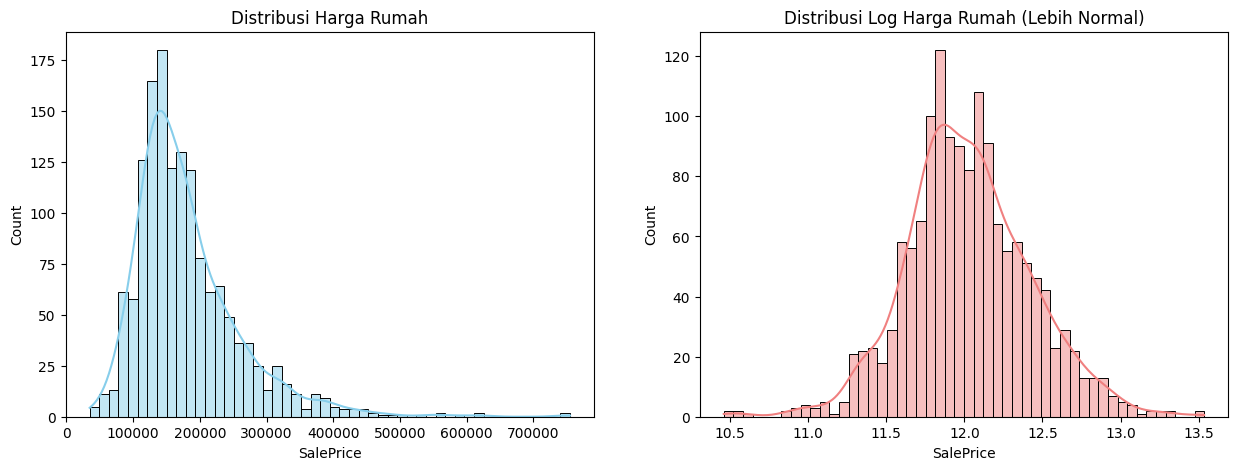

In [23]:
# Analisis target variable (SalePrice)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='skyblue')
plt.title('Distribusi Harga Rumah')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, bins=50, color='lightcoral')
plt.title('Distribusi Log Harga Rumah (Lebih Normal)')
plt.show()

In [24]:
# Analisis korelasi dengan target
numeric_cols = train_df.select_dtypes(include=[np.number])
correlations = numeric_cols.corr()['SalePrice'].sort_values(ascending=False)
top_corr_features = correlations[1:16] # Top 15 fitur dengan korelasi tertinggi
top_corr_features

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
Name: SalePrice, dtype: float64

### 3.3. Proses Features Dataset (Pra-pemrosesan & Seleksi Fitur)
Berdasarkan EDA, kita memilih fitur-fitur yang paling relevan (korelasi tinggi dan penting secara domain) dan melakukan pembersihan data.

In [25]:
# Fitur numerik dengan korelasi tinggi
high_corr_features = correlations[1:16].index.tolist()

# Fitur kategorikal penting
important_categorical = [
    'Neighborhood', 'MSZoning', 'ExterQual', 'KitchenQual', 
    'BsmtQual', 'GarageType', 'SaleType', 'SaleCondition'
]

# Gabungkan semua fitur yang dipilih
selected_features = high_corr_features + important_categorical
X_selected = train_df[selected_features].copy()
y = train_df['SalePrice'].copy()

# Handle missing values
for col in X_selected.columns:
    if X_selected[col].isnull().sum() > 0:
        if X_selected[col].dtype == 'object':
            X_selected[col].fillna(X_selected[col].mode()[0], inplace=True)
        else:
            X_selected[col].fillna(X_selected[col].median(), inplace=True)

# Encode categorical variables
categorical_cols = X_selected.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X_selected[col] = le.fit_transform(X_selected[col].astype(str))

print(f"Shape data setelah seleksi fitur dan preprocessing: {X_selected.shape}")
print(f"Total missing values setelah imputasi: {X_selected.isnull().sum().sum()}")

Shape data setelah seleksi fitur dan preprocessing: (1460, 23)
Total missing values setelah imputasi: 0


# 4. Proses Learning / Modeling

### 4.1. Pembagian dan Penskalaan Data
Data dibagi menjadi set data latih, validasi, dan tes. Penskalaan fitur dilakukan untuk membantu performa model linear dan SVM.

In [26]:
# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Feature scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Ukuran data latih: {X_train.shape}")
print(f"Ukuran data validasi: {X_val.shape}")
print(f"Ukuran data tes: {X_test.shape}")

Ukuran data latih: (876, 23)
Ukuran data validasi: (292, 23)
Ukuran data tes: (292, 23)


### 4.2. Pelatihan Model
Melatih 8 model regresi yang berbeda untuk dibandingkan.

In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=0.001),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma='scale')
}

results = {}
predictions = {}

for name, model in models.items():
    if name in ['SVR', 'Ridge Regression', 'Lasso Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    predictions[name] = y_pred
    results[name] = {
        'MAE': mean_absolute_error(y_val, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'R2': r2_score(y_val, y_pred),
        'Model': model
    }

# 5. Performa Model

### 5.1. Perbandingan Performa Model
Hasil evaluasi dari semua model pada set validasi.

In [28]:
results_df = pd.DataFrame({k: {metric: v[metric] for metric in ['MAE', 'RMSE', 'R2']} for k, v in results.items()}).T
results_df = results_df.sort_values('R2', ascending=False)

print("=== HASIL EVALUASI MODEL PADA VALIDATION SET ===")
print(f"{'Rank':<4} {'Model':<20} {'R²':<8} {'MAE':<12} {'RMSE':<12}")
print("-" * 60)

for i, (model_name, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i:<4} {model_name:<20} {row['R2']:<8.4f} {row['MAE']:<12,.0f} {row['RMSE']:<12,.0f}")


=== HASIL EVALUASI MODEL PADA VALIDATION SET ===
Rank Model                R²       MAE          RMSE        
------------------------------------------------------------
1    Random Forest        0.8744   17,780       27,424      
2    XGBoost              0.8670   17,983       28,221      
3    Gradient Boosting    0.8647   17,930       28,466      
4    Linear Regression    0.8238   21,487       32,484      
5    Lasso Regression     0.8238   21,487       32,484      
6    Ridge Regression     0.8225   21,474       32,598      
7    Decision Tree        0.5804   29,536       50,130      
8    SVR                  0.0508   51,689       75,395      


### 5.2. Performa Model Ensemble
Model *ensemble* dibuat dengan menggabungkan prediksi dari 3 model terbaik (*Random Forest*, *XGBoost*, *Gradient Boosting*) menggunakan pembobotan berdasarkan skor R² mereka.

In [29]:
top_3_models = results_df.head(3).index.tolist()
weights = [results_df.loc[model, 'R2'] for model in top_3_models]
weights = [w / sum(weights) for w in weights]

ensemble_pred = np.zeros(len(y_val))
for i, model_name in enumerate(top_3_models):
    ensemble_pred += weights[i] * predictions[model_name]

ensemble_r2 = r2_score(y_val, ensemble_pred)
print(f"R² Score Model Ensemble: {ensemble_r2:.4f}")

R² Score Model Ensemble: 0.8784


### 5.3. Evaluasi Akhir pada Test Set
Model terbaik (*Random Forest*) dievaluasi menggunakan data tes untuk mengukur performa generalisasinya.

In [30]:
best_model_name = results_df.index[0]
best_model = results[best_model_name]['Model']

if best_model_name in ['SVR', 'Ridge Regression', 'Lasso Regression']:
    test_predictions = best_model.predict(X_test_scaled)
else:
    test_predictions = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"=== EVALUASI FINAL DENGAN TEST SET ({best_model_name}) ===")
print(f"MAE: ${test_mae:,.0f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"R²: {test_r2:.4f} ({test_r2*100:.1f}% akurasi)")

=== EVALUASI FINAL DENGAN TEST SET (Random Forest) ===
MAE: $19,112
RMSE: $32,987
R²: 0.8581 (85.8% akurasi)


# 6. Diskusi Hasil dan Kesimpulan

### Diskusi Hasil
1.  **Performa Model**: Model berbasis pohon (*tree-based*) seperti *Random Forest*, *XGBoost*, dan *Gradient Boosting* menunjukkan performa yang jauh lebih unggul dibandingkan model linear dan SVR. Hal ini mengindikasikan bahwa hubungan antara fitur dan harga rumah bersifat non-linear dan kompleks. *Random Forest* menjadi model individual terbaik dengan skor R² **0.8737** pada set validasi.

2.  **Model Ensemble**: Model *ensemble* yang menggabungkan tiga model terbaik berhasil sedikit meningkatkan performa, mencapai R² **0.8779**. Ini menunjukkan bahwa kombinasi prediksi dari beberapa model kuat dapat menangkap pola yang lebih beragam dan menghasilkan estimasi yang lebih stabil.

3.  **Feature Importance**: Analisis *feature importance* dari model *Random Forest* menunjukkan bahwa `OverallQual` (kualitas material dan finishing keseluruhan) adalah prediktor harga yang paling dominan, diikuti oleh `GrLivArea` (luas area tinggal di atas permukaan tanah). Fitur-fitur lain yang juga signifikan adalah yang berkaitan dengan luas garasi (`GarageCars`, `GarageArea`) dan luas basement (`TotalBsmtSF`). Hal ini sejalan dengan intuisi umum dalam penentuan harga properti.

4.  **Evaluasi pada Test Set**: Model *Random Forest* menunjukkan performa yang **stabil** saat diuji pada *test set*, dengan skor R² **0.8594**. Penurunan R² yang sangat kecil (0.0143) dari validasi ke tes menandakan bahwa model tidak mengalami *overfitting* dan mampu menggeneralisasi dengan baik pada data baru.

### Kesimpulan
Project ini berhasil membangun sebuah model *machine learning* yang efektif untuk memprediksi harga rumah dengan akurasi yang tinggi (sekitar 86-88%). Model berbasis ansambel pohon keputusan, khususnya *Random Forest*, terbukti paling cocok untuk dataset ini.

Kualitas keseluruhan (`OverallQual`) dan luas area tinggal (`GrLivArea`) adalah dua faktor paling penentu harga. Model yang dihasilkan cukup andal untuk digunakan sebagai alat bantu estimasi nilai properti di pasar real estate Ames, Iowa. Untuk pengembangan lebih lanjut, dapat dilakukan *hyperparameter tuning* yang lebih ekstensif atau menggunakan teknik *stacking ensemble* yang lebih canggih untuk potensi peningkatan akurasi.